In [1]:
import torch
import random
import urllib.request
import imageio as imio
from einops import rearrange
import matplotlib.pyplot as plt
from IPython.display import clear_output, HTML, display
import numpy as np

import sys
sys.path.append('..')

from models.model_utils import TrajectorySampler
from builders.builders import build_dataloader
from utils.utils import instantiate_from_config
from notebooks.walkthrough_utils import get_smooth_trajectory
from utils.camera_trajectory import rotate_n, go_forward, go_backward

import copy
from PIL import ImageDraw, Image, ImageFont
import torchvision.transforms.functional as FF

/home/gridsan/fangd/.conda/envs/gsn/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = 'gpu'
else:
    device = 'cpu'
print(device)

gpu


In [3]:
COLORS = torch.tensor([[0.9804, 0.9451, 0.9176],
        [0.8980, 0.5255, 0.0235],
        [0.3647, 0.4118, 0.6941],
        [0.3216, 0.7373, 0.6392],
        [0.6000, 0.7882, 0.2706],
        [0.1843, 0.5412, 0.7686],
        [0.6471, 0.6667, 0.6000],
        [0.8549, 0.6471, 0.1059],
        [0.4627, 0.3059, 0.6235],
        [0.8000, 0.3804, 0.6902],
        [0.9294, 0.3922, 0.3529],
        [0.1412, 0.4745, 0.4235],
        [0.4000, 0.7725, 0.8000],
        [0.9647, 0.8118, 0.4431],
        [0.9725, 0.6118, 0.4549],
        [0.8627, 0.6902, 0.9490],
        [0.5294, 0.7725, 0.3725],
        [0.6196, 0.7255, 0.9529],
        [0.9961, 0.5333, 0.6941],
        [0.7882, 0.8588, 0.4549],
        [0.5451, 0.8784, 0.6431],
        [0.7059, 0.5922, 0.9059],
        [0.7020, 0.7020, 0.7020],
        [0.5216, 0.3608, 0.4588],
        [0.8510, 0.6863, 0.4196],
        [0.6863, 0.3922, 0.3451],
        [0.4510, 0.4353, 0.2980],
        [0.3216, 0.4157, 0.5137],
        [0.3843, 0.3255, 0.4667],
        [0.4078, 0.5216, 0.3608],
        [0.6118, 0.6118, 0.3686],
        [0.6275, 0.3804, 0.4667],
        [0.5490, 0.4706, 0.3647],
        [0.4863, 0.4863, 0.4863]])

## Load Pre-trained Model and Dataloader

In [4]:
# download pretrained model (takes anywhere from a few seconds to a few minutes depending on internet speed)
# model_url = 'https://docs-assets.developer.apple.com/ml-research/models/gsn/replica_128x128.ckpt'
# checkpoint_filename = 'replica_128x128.ckpt'
# urllib.request.urlretrieve(model_url, checkpoint_filename)

In [5]:
# Note: adjust the data path here if data is in a different location than default
checkpoint_filename = '../logsReplica/checkpoints/last.ckpt'
# checkpoint_filename = '../logsReplica/checkpoints/gsn-model-best-fid.ckpt'
data_path = '../data/replica_all'

checkpoint = torch.load(checkpoint_filename)
state_dict = checkpoint['state_dict']

print("model loaded")

# get rid of all the inception params which are leftover from FID metric
keys_for_deletion = []
for key in state_dict.keys():
    if 'fid' in key:
        keys_for_deletion.append(key)
for key in keys_for_deletion:
    del state_dict[key]

opt = checkpoint['opt']
opt.data_config.data_dir = data_path

# remove jitter
opt.model_config.params.blob_maker_config.params.feature_jitter_xy = 0
opt.model_config.params.blob_maker_config.params.feature_jitter_shift = 0
opt.model_config.params.blob_maker_config.params.feature_jitter_angle = 0

model loaded


In [6]:
# create dataloader
data_module = build_dataloader(opt.data_config, verbose=False)

# collect a set of real trajectories from the dataset
real_Rts = data_module.train_loader.dataset.get_trajectory_Rt()
trajectory_sampler = TrajectorySampler(real_Rts=real_Rts, mode=opt.model_config.params.trajectory_mode)

# initialize model and load state
gsn = instantiate_from_config(opt.model_config).cuda().eval()
gsn.set_trajectory_sampler(trajectory_sampler=trajectory_sampler)
gsn.load_state_dict(state_dict, strict=True)

# increase nerf_out_res after loading model to generate higher res samples (i.e., implicit upsampling)
gsn.generator_config.params.nerf_out_res *= 2
# trade render speed for memory by rendering smaller patches at a time
gsn.patch_size = 32

# load a batch of data so that we can use the camera parameters
real_data = next(iter(data_module.train_dataloader()))

[Errno 2] No such file or directory: 'models/op/fused_bias_act.cpp'
There was something wrong with the CUDA kernels
Reverting to native PyTorch implementation


## Get noise latent and blobs

In [7]:
torch.seed()
device = 'cuda'
# z_dim = opt.model_config.params.decoder_config.params.z_dim
z_dim = opt.model_config.params.blob_maker_config.params.noise_dim
z = torch.randn(1, z_dim, device=device)

In [8]:
truncate = 0.
gsn.blob_maker.device = device
gsn.blob_maker.get_mean_latent(100)

def draw_labels(img, layout, T, colors, layout_i=0):
    font = ImageFont.truetype('LiberationSans-Bold.ttf', 10)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    mask = layout['sizes'][layout_i, 1:] > T
    idmap = torch.arange(len(mask))[mask]
    blob = {k: layout[k][layout_i][mask].mul(128).tolist() for k in ('xs', 'ys')}
    for i, (x, y) in enumerate(zip(blob['xs'], blob['ys'])):
        I = idmap[i]
        _, h = draw.textsize(str(I), font=font)
        w = h
        
        color = tuple(colors[I + 1].mul(255).round().int().tolist())
        draw.text((x - w / 2, y - h / 2), f'{I}', fill=color, stroke_width=1, font=font, stroke_fill=(0, 0, 0))
    return FF.to_tensor(img).permute(1, 2, 0), img


def for_canvas(img):
    return img.detach()[0].round().permute(1, 2, 0).clamp(min=0, max=255).cpu().numpy().astype(np.uint8)

Computing mean latent: 100%|██████████| 100/100 [00:01<00:00, 92.59it/s]


tensor([[0.6888, 0.8043, 0.6771, 0.4117, 0.3690, 0.6389, 0.0502, 0.5804, 0.5877,
         0.5374]], device='cuda:0')
dict_keys(['scores_pyramid', 'feature_grid', 'feature_img', 'entropy_img', 'xs', 'ys', 'covs', 'raw_scores', 'sizes', 'composed_scores', 'features', 'spatial_style'])
tensor([[-1.2483,  0.2932,  0.0092,  1.6638, -1.8216,  0.5803, -2.4768,  0.8600,
          0.2845,  0.8763,  1.3350]], device='cuda:0')
torch.Size([1, 3, 128, 128])
(128, 128, 3)


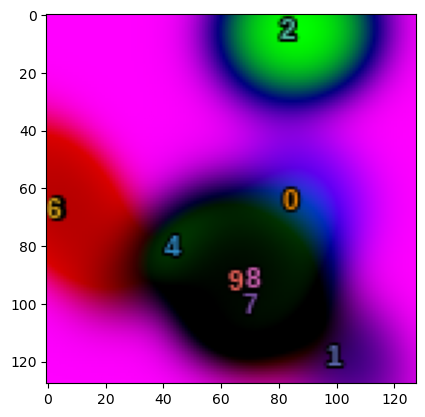

In [9]:
torch.manual_seed(1)

with torch.no_grad():
    layout = gsn.blob_maker.generate_layout(z, viz = True, viz_size=[128, 128], no_jitter = True, ret_layout = True)    
    print(layout['xs'])

print(layout.keys())
print(layout['sizes'])

blob_im = layout['feature_img']
print(blob_im.shape)

blobs = for_canvas(blob_im.mul(255))
print(blobs.shape)

labeled_blobs, labeled_blobs_img = draw_labels(blobs, layout, truncate, COLORS)

plt.imshow(labeled_blobs)

dict_keys(['scores_pyramid', 'feature_grid', 'feature_img', 'entropy_img', 'xs', 'ys', 'covs', 'raw_scores', 'sizes', 'composed_scores', 'features', 'spatial_style'])
tensor([[0.6888, 0.8043, 0.6771, 0.4117, 0.3690, 0.6389, 0.0502, 0.5804, 0.5877,
         0.5374]], device='cuda:0')
tensor([[0.6888, 0.8043, 0.6771, 0.4117, 0.3690, 0.6389, 0.0502, 0.5804, 0.5877,
         0.5374]], device='cuda:0')
dict_keys(['scores_pyramid', 'feature_grid', 'feature_img', 'entropy_img', 'xs', 'ys', 'covs', 'raw_scores', 'sizes', 'composed_scores', 'features', 'spatial_style'])
torch.Size([1, 3, 128, 128])
(128, 128, 3)


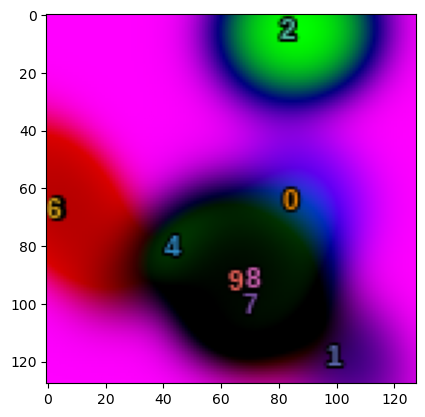

In [10]:
torch.manual_seed(1)

with torch.no_grad():
    layout_copy = copy.deepcopy(layout)
    print(layout_copy.keys())

#     layout_copy['xs'][0, 0] -= 0.3
#     layout_copy['ys'][0, 6] += 0.1
    
    print(layout['xs'])
    print(layout_copy['xs'])
    
    del layout_copy['feature_img']
    edited_layout = gsn.blob_maker.generate_layout(layout = layout_copy, viz = True, ret_layout = True, no_jitter = True,
                                                  viz_size = [128, 128], covs_raw = False)
        
print(edited_layout.keys())

edited_blob_im = edited_layout['feature_img']
print(edited_blob_im.shape)

edited_blobs = for_canvas(edited_blob_im.mul(255))
print(edited_blobs.shape)

edited_labeled_blobs, edited_labeled_blobs_img = draw_labels(edited_blobs, edited_layout, truncate, COLORS)

plt.imshow(edited_labeled_blobs)

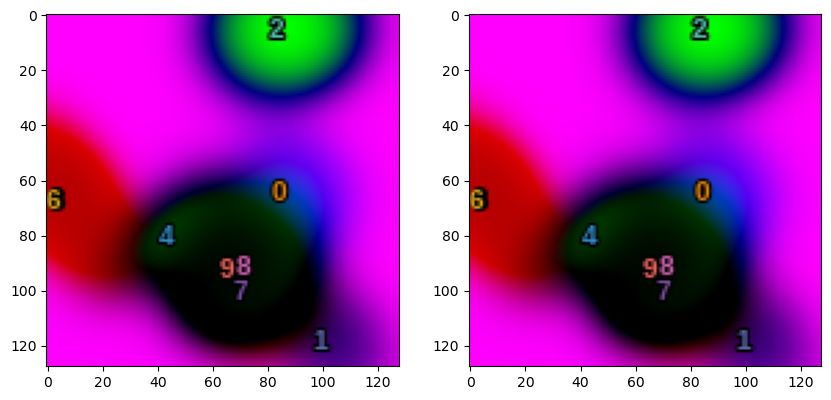

In [11]:
f, axarr = plt.subplots(1, 2, figsize=(10, 10))
axarr[0].imshow(labeled_blobs)
axarr[1].imshow(edited_labeled_blobs)
plt.show()

/home/gridsan/fangd/.conda/envs/gsn/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


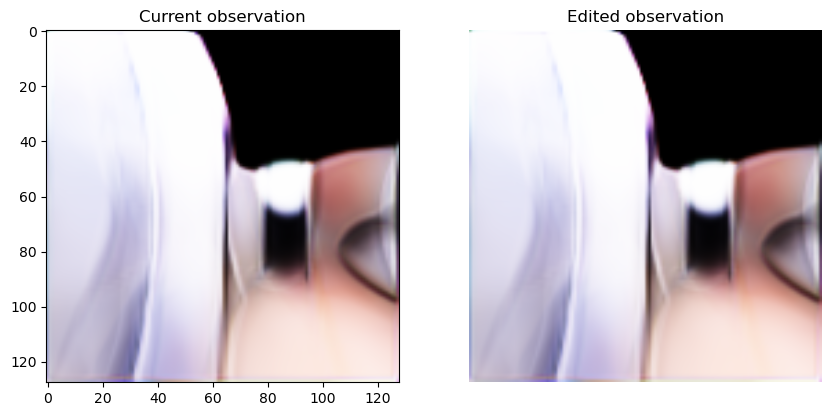

In [12]:
# intrinsic camera matrix from real data
K_current = real_data['K'].to(device)
# initialize extrinsic camera matrix at the center of the scene
Rt_current = torch.eye(4, device=device).view(1, 1, 4, 4)
camera_params = {'K': K_current, 'Rt': Rt_current}

with torch.no_grad():
#     layout2 = gsn.blob_maker(z, ema = True, truncate = truncate)
#     print((layout['feature_grid'] == layout2['input']).all())

    l = layout
    SPLAT_KEYS = ['spatial_style', 'scores_pyramid']
    gen_input = {
            'input': l['feature_grid'],
            'styles': {k: l[k] for k in SPLAT_KEYS},
        }
    
    fake_rgb, fake_depth, Rt, K = gsn.generate_from_layout(gen_input, camera_params = camera_params)
    
    l = edited_layout
    SPLAT_KEYS = ['spatial_style', 'scores_pyramid']
    gen_input = {
            'input': l['feature_grid'],
            'styles': {k: l[k] for k in SPLAT_KEYS},
        }
    
    fake_rgb2, fake_depth2, Rt2, K2 = gsn.generate_from_layout(gen_input, camera_params = camera_params)


rgb_current = rearrange(fake_rgb, 'b t c h w -> (b t h) w c').cpu().detach()
rgb_current2 = rearrange(fake_rgb2, 'b t c h w -> (b t h) w c').cpu().detach()

f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(rgb_current, interpolation='bilinear')
ax[0].set_title('Current observation')

ax[1].imshow(rgb_current2, interpolation='bilinear')
ax[1].set_title('Edited observation')
plt.axis('off')
plt.show()

In [14]:
stacked_imgs = []
for i in range(20):
    torch.manual_seed(1)
    with torch.no_grad():
        
        layout = gsn.blob_maker.generate_layout(z, viz = True, viz_size=[128, 128], no_jitter = True, 
                                                ret_layout = True)

        layout_copy = copy.deepcopy(layout)
        
#         layout_copy['xs'][0, 9] = 0.5
#         layout_copy['ys'][0, 9] = 0.5

#         layout_copy['xs'][0, 0] += i*0.4/10
        layout_copy['ys'][0, 2] += i*0.2/10

#         layout_copy['sizes'][0, 10] -= i*5/15

        del layout_copy['feature_img']
        edited_layout = gsn.blob_maker.generate_layout(layout = layout_copy, viz = True, ret_layout = True, no_jitter = True,
                                                      viz_size = [128, 128], covs_raw = False)
        
    edited_blob_im = edited_layout['feature_img']
    edited_blobs = for_canvas(edited_blob_im.mul(255))
    edited_labeled_blobs, edited_labeled_blobs_img = draw_labels(edited_blobs, edited_layout, truncate, COLORS)
        
    l = layout
    SPLAT_KEYS = ['spatial_style', 'scores_pyramid']
    gen_input = {
            'input': l['feature_grid'],
            'styles': {k: l[k] for k in SPLAT_KEYS},
        }
    fake_rgb, fake_depth, Rt, K = gsn.generate_from_layout(gen_input, camera_params = camera_params)
    
    l = edited_layout
    SPLAT_KEYS = ['spatial_style', 'scores_pyramid']
    gen_input = {
            'input': l['feature_grid'],
            'styles': {k: l[k] for k in SPLAT_KEYS},
        }
    fake_rgb2, fake_depth2, Rt2, K2 = gsn.generate_from_layout(gen_input, camera_params = camera_params)
    
    rgb_current = rearrange(fake_rgb, 'b t c h w -> (b t h) w c').cpu().detach()
    rgb_current2 = rearrange(fake_rgb2, 'b t c h w -> (b t h) w c').cpu().detach()
    
    stacked_imgs.append(torch.hstack([rgb_current, rgb_current2, edited_labeled_blobs]))

animation_filename = 'moving_blobs.gif'
imio.mimsave(animation_filename, stacked_imgs, fps=5)
display(HTML('<img src={}>'.format(animation_filename)))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

## Interactive Walkthrough
Use wasd to explore the scene. Enter 'q' to stop exploring.

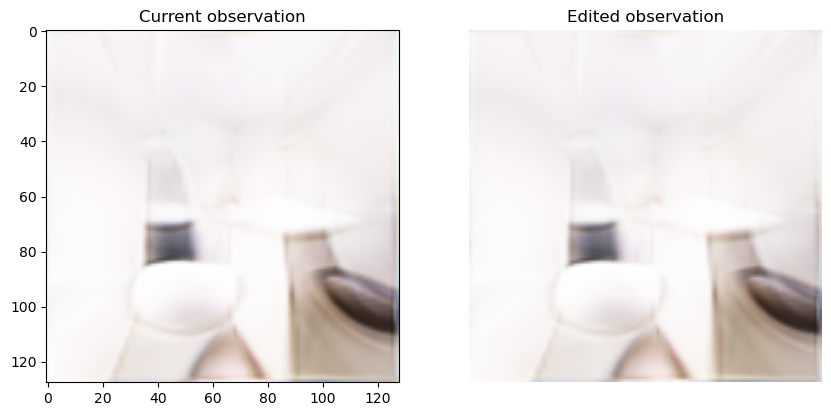

a/w/d/s q


In [226]:
# intrinsic camera matrix from real data
K_current = real_data['K'].to(device)
# initialize extrinsic camera matrix at the center of the scene
Rt_current = torch.eye(4, device=device).view(1, 1, 4, 4)

trajectory = {'rgb': [], 'depth': [], 'Rt': [], 'K': []}

while True:
    torch.manual_seed(1)
    camera_params = {'K': K_current, 'Rt': Rt_current}
    
    with torch.no_grad():
#         fake_rgb, fake_depth, Rt, K = gsn(z, camera_params=camera_params)
        
       

        layout = gsn.blob_maker.generate_layout(z, viz = True, viz_size=[128, 128], no_jitter = True, 
                                                ret_layout = True)
        layout_copy = copy.deepcopy(layout)
        
#         layout_copy['xs'][0, 2] += 0.3
#         layout_copy['sizes'][0, 3] += 1
        
        del layout_copy['feature_img']
        edited_layout = gsn.blob_maker.generate_layout(layout = layout_copy, viz = True, ret_layout = True, no_jitter = True,
                                                          viz_size = [128, 128], covs_raw = False)

        edited_blob_im = edited_layout['feature_img']
        edited_blobs = for_canvas(edited_blob_im.mul(255))
        edited_labeled_blobs, edited_labeled_blobs_img = draw_labels(edited_blobs, edited_layout, truncate, COLORS)

        l = layout
        SPLAT_KEYS = ['spatial_style', 'scores_pyramid']
        gen_input = {
                'input': l['feature_grid'],
                'styles': {k: l[k] for k in SPLAT_KEYS},
            }
        fake_rgb, fake_depth, Rt, K = gsn.generate_from_layout(gen_input, camera_params = camera_params)

        l = edited_layout
        SPLAT_KEYS = ['spatial_style', 'scores_pyramid']
        gen_input = {
                'input': l['feature_grid'],
                'styles': {k: l[k] for k in SPLAT_KEYS},
            }
        fake_rgb2, fake_depth2, Rt2, K2 = gsn.generate_from_layout(gen_input, camera_params = camera_params)

    
    trajectory['rgb'].append(fake_rgb)
    trajectory['depth'].append(fake_depth)
    trajectory['Rt'].append(Rt)
    trajectory['K'].append(K)
    
    rgb_current = rearrange(fake_rgb, 'b t c h w -> (b t h) w c').cpu().detach()
    rgb_current2 = rearrange(fake_rgb2, 'b t c h w -> (b t h) w c').cpu().detach()
    
    clear_output()

    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(rgb_current, interpolation='bilinear')
    ax[0].set_title('Current observation')

    ax[1].imshow(rgb_current2, interpolation='bilinear')
    ax[1].set_title('Edited observation')
    plt.axis('off')
    plt.show()

    action = input("a/w/d/s")
    if action == 'a':
        # Turn left
        Rt = rotate_n(n=-30.0).to(device)
        Rt_current = torch.bmm(Rt.unsqueeze(0), Rt_current[0]).unsqueeze(0)
    if action == 'd':
        # Turn right
        Rt = rotate_n(n=30.0).to(device)
        Rt_current = torch.bmm(Rt.unsqueeze(0), Rt_current[0]).unsqueeze(0)
    if action == 'w':
        # Go forwardw
        
        Rt_current = go_forward(Rt_current, step=opt.model_config.params.voxel_size / 0.6)
    if action == 's':
        # Go backward
        Rt_current = go_backward(Rt_current, step=opt.model_config.params.voxel_size / 0.6)
    if action == 'q':
        break
        
for key in trajectory.keys():
    trajectory[key] = torch.cat(trajectory[key], dim=1)

## Generate Animation
Fit a spline to the camera trajectory and uniformly render frames along it to produce a smooth animation.

In [227]:
# jitter camera pose a tiny amount to make sure each pose is unique
# (to avoid problems with trajectory smoothing)
trajectory['Rt'] = trajectory['Rt'] + torch.rand_like(trajectory['Rt']) * 1e-5

# fit a smooth spline to the trajectory keypoints
n_keypoints = len(trajectory['Rt'][0])
new_Rts = get_smooth_trajectory(Rt=trajectory['Rt'][0], n_frames=5 * n_keypoints, subsample=3)
n_steps = len(new_Rts)

# render frames along new smooth trajectory
resampled_trajectory = {'rgb': [], 'depth': [], 'Rt': [], 'K': []}
for i in range(n_steps):
    if i % 10 == 0:
        print('Rendering frame {}/{}'.format(i, n_steps))
    
    camera_params = {'K': K_current[:1, :1], 'Rt': new_Rts[i:i+1].to(device)}
    
    with torch.no_grad():
        fake_rgb, fake_depth, Rt, K = gsn(z, camera_params=camera_params)

    resampled_trajectory['rgb'].append(fake_rgb)
    resampled_trajectory['depth'].append(fake_depth)
    resampled_trajectory['Rt'].append(Rt)
    resampled_trajectory['K'].append(K)

for key in resampled_trajectory.keys():
    resampled_trajectory[key] = torch.cat(resampled_trajectory[key], dim=1)

imgs = []
for i in range(n_steps):
    im = resampled_trajectory['rgb'][0, i].permute(1, 2, 0).detach().cpu()
    imgs.append((im * 255).byte())

# save gif with random unique name
n = ''.join(random.choice('0123456789ABCDEF') for i in range(5))
animation_filename = 'camera_trajectory_{}.gif'.format(n)
print('Saving animation to {}\n'.format(animation_filename))
imio.mimsave(animation_filename, imgs, fps=30)

display(HTML('<img src={}>'.format(animation_filename)))

Rendering frame 0/55
Rendering frame 10/55
Rendering frame 20/55
Rendering frame 30/55
Rendering frame 40/55
Rendering frame 50/55
Saving animation to camera_trajectory_14555.gif

